# Setup

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from warnings import filterwarnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, GlobalMaxPooling1D, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.metrics import F1Score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm


filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

c:\Users\user\anaconda3\envs\bertenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
PATH = "../data/data_cleaned.csv"
df = pd.read_csv(PATH)
df.head()

,status,cleaned_text,statement length,contains_num,capital_ratio,word_count,avg_word_length,sentence_count,avg_sentence_length,lemmatized_text
0,Anxiety,oh my gosh,-0.667029,-0.682949,-0.410857,-0.671471,-0.082738,-0.487861,-0.372609,oh gosh
1,Anxiety,trouble sleeping confused mind restless heart ...,-0.603345,-0.682949,-0.197571,-0.629393,0.028487,-0.394956,-0.340326,trouble sleeping confused mind restless heart ...
2,Anxiety,all wrong back off dear forward doubt stay in ...,-0.586835,-0.682949,-0.053087,-0.605348,-0.000472,-0.394956,-0.308043,wrong back dear forward doubt stay restless re...
3,Anxiety,i have shifted my focus to something else but ...,-0.606883,-0.682949,0.041831,-0.611359,0.006607,-0.487861,-0.243477,shifted focus something else still worried
4,Anxiety,i am restless and restless it is been a month ...,-0.593911,-0.682949,0.007666,-0.593326,-0.062590,-0.394956,-0.308043,restless restless month boy mean


In [22]:
df[df['lemmatized_text'].isnull()]

,status,cleaned_text,statement length,contains_num,capital_ratio,word_count,avg_word_length,sentence_count,avg_sentence_length,lemmatized_text
722,Normal,what should i do,-0.655236,-0.682949,1.295428,-0.665460,-0.109828,-0.487861,-0.340326,NaN
1203,Normal,just on again,-0.663491,-0.682949,0.597402,-0.671471,-0.011627,-0.487861,-0.372609,NaN
1842,Normal,where are you,-0.662312,-0.682949,-0.410857,-0.671471,-0.059034,-0.487861,-0.372609,NaN
2321,Normal,where is this,-0.663491,-0.682949,0.597402,-0.671471,-0.011627,-0.487861,-0.372609,NaN
2596,Normal,can you not,-0.664670,-0.682949,0.821460,-0.671471,-0.094590,-0.487861,-0.372609,NaN
...,...,...,...,...,...,...,...,...,...,...
33413,Normal,how did you do that,-0.655236,-0.682949,-0.410857,-0.659449,-0.082738,-0.487861,-0.340326,NaN
33473,Normal,how can he do that,-0.656415,-0.682949,-0.410857,-0.659449,-0.094590,-0.487861,-0.340326,NaN
33559,Normal,why did they do that,-0.654056,-0.682949,-0.410857,-0.659449,-0.070886,-0.487861,-0.340326,NaN
35858,Suicidal,,-0.623394,1.464237,2.851158,-0.641415,0.272818,-0.487861,-0.388750,NaN


In [23]:
df.dropna(subset=['lemmatized_text'], inplace=True)

In [24]:
LABEL = 'status'

In [25]:
X = df.drop(LABEL, axis=1)
y = df[LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Tf-idf Vectorizer and Label Encoding

In [8]:
# Train vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train_feat = X_train.drop(['lemmatized_text','cleaned_text'], axis=1).values
X_train_text = tfidf_vectorizer.fit_transform(X_train['lemmatized_text']).toarray()
X_train_all = np.hstack((X_train_feat, X_train_text))

X_test_feat = X_test.drop(['lemmatized_text','cleaned_text'], axis=1).values
X_test_text = tfidf_vectorizer.transform(X_test['lemmatized_text']).toarray()
X_test_all = np.hstack((X_test_feat, X_test_text))

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

## Baseline Model

Model: Random Forest
F1 Score: 0.7068
                      precision    recall  f1-score   support

             Anxiety       0.81      0.66      0.73       725
             Bipolar       0.90      0.48      0.62       500
          Depression       0.60      0.79      0.68      3019
              Normal       0.86      0.94      0.90      3189
Personality disorder       1.00      0.14      0.25       179
              Stress       0.73      0.17      0.28       459
            Suicidal       0.66      0.55      0.60      2128

            accuracy                           0.72     10199
           macro avg       0.80      0.53      0.58     10199
        weighted avg       0.74      0.72      0.71     10199



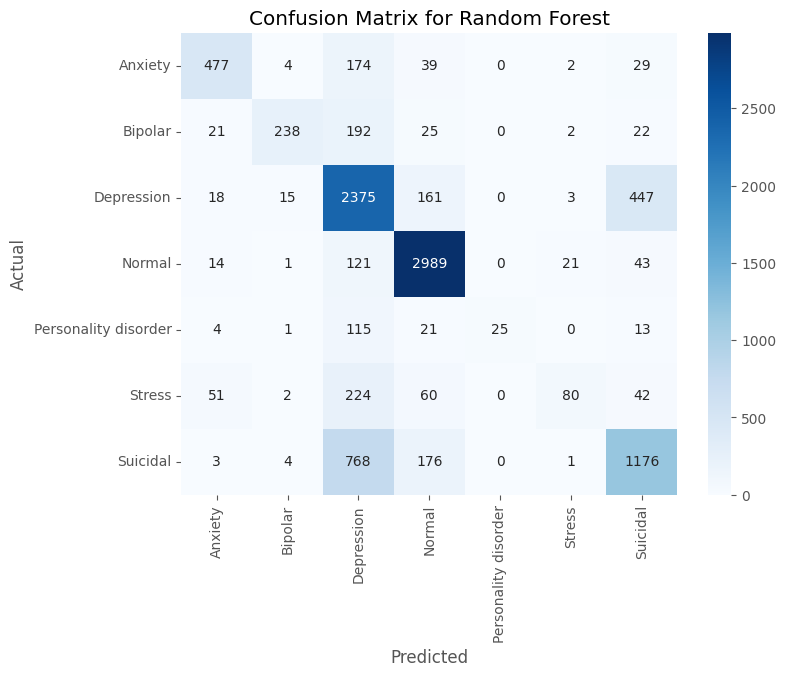

Model: CatBoost
F1 Score: 0.7749
                      precision    recall  f1-score   support

             Anxiety       0.83      0.81      0.82       725
             Bipolar       0.85      0.64      0.73       500
          Depression       0.73      0.75      0.74      3019
              Normal       0.87      0.95      0.91      3189
Personality disorder       0.94      0.42      0.58       179
              Stress       0.63      0.56      0.59       459
            Suicidal       0.70      0.66      0.68      2128

            accuracy                           0.78     10199
           macro avg       0.79      0.68      0.72     10199
        weighted avg       0.78      0.78      0.77     10199



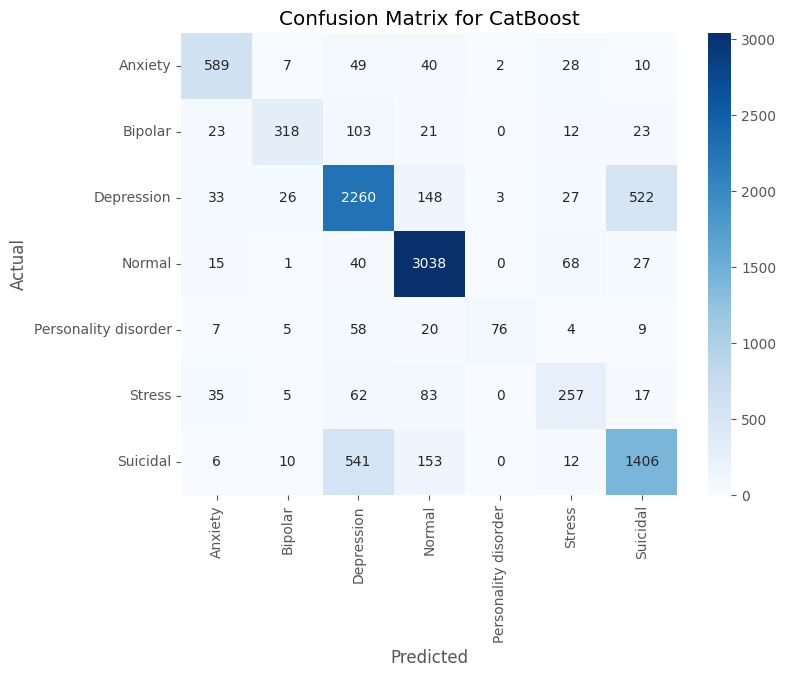

Model: XGBoost
F1 Score: 0.7767
                      precision    recall  f1-score   support

             Anxiety       0.83      0.80      0.81       725
             Bipolar       0.85      0.67      0.75       500
          Depression       0.72      0.75      0.74      3019
              Normal       0.88      0.95      0.91      3189
Personality disorder       0.89      0.46      0.61       179
              Stress       0.63      0.58      0.61       459
            Suicidal       0.70      0.66      0.68      2128

            accuracy                           0.78     10199
           macro avg       0.79      0.70      0.73     10199
        weighted avg       0.78      0.78      0.78     10199



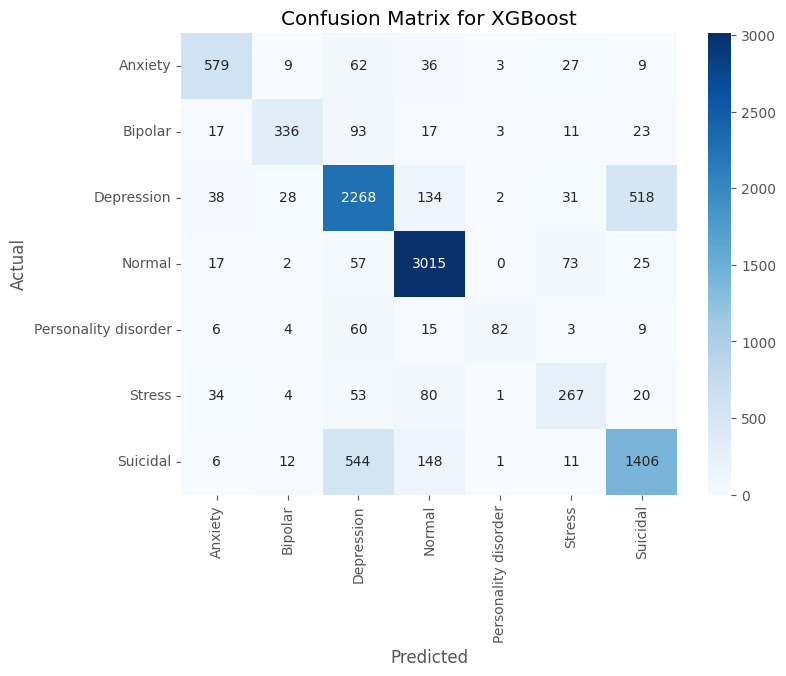

Model: LightGBM


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


F1 Score: 0.7792
                      precision    recall  f1-score   support

             Anxiety       0.82      0.80      0.81       725
             Bipolar       0.83      0.69      0.75       500
          Depression       0.73      0.75      0.74      3019
              Normal       0.88      0.95      0.92      3189
Personality disorder       0.90      0.45      0.60       179
              Stress       0.66      0.58      0.62       459
            Suicidal       0.69      0.67      0.68      2128

            accuracy                           0.78     10199
           macro avg       0.79      0.70      0.73     10199
        weighted avg       0.78      0.78      0.78     10199



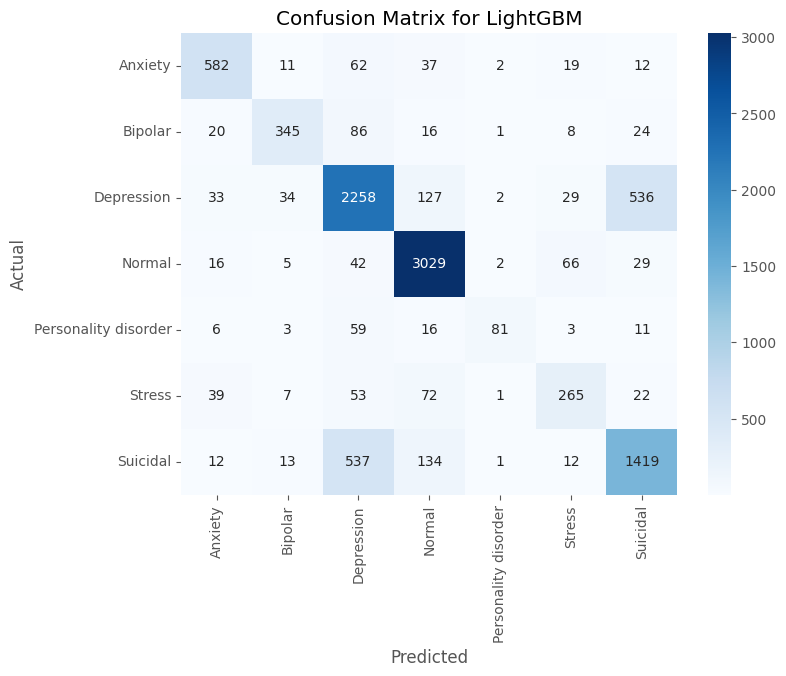

Model: SVM
F1 Score: 0.7346
                      precision    recall  f1-score   support

             Anxiety       0.85      0.72      0.78       725
             Bipolar       0.89      0.51      0.65       500
          Depression       0.64      0.77      0.70      3019
              Normal       0.85      0.94      0.89      3189
Personality disorder       1.00      0.15      0.26       179
              Stress       0.66      0.37      0.47       459
            Suicidal       0.70      0.60      0.64      2128

            accuracy                           0.74     10199
           macro avg       0.80      0.58      0.63     10199
        weighted avg       0.75      0.74      0.73     10199



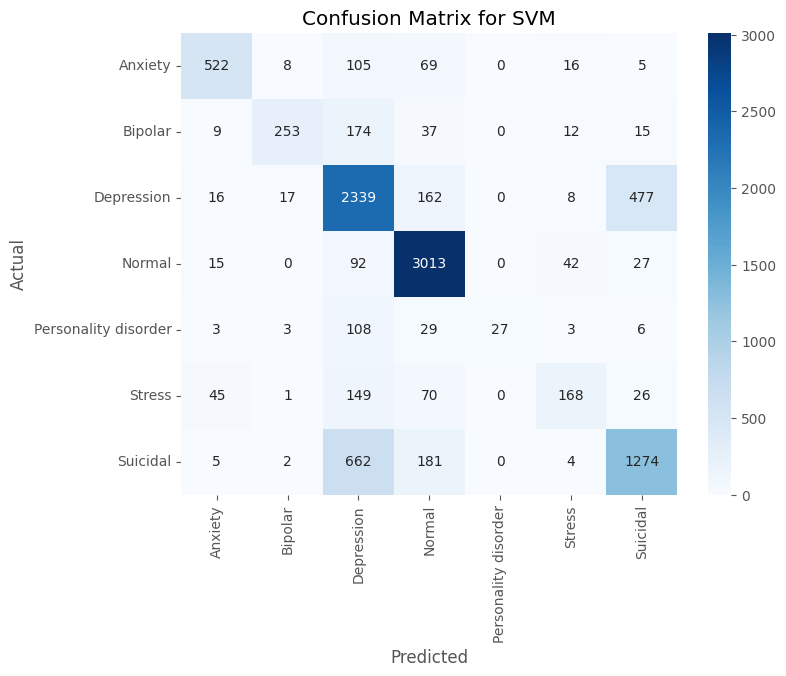

In [9]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, task_type="GPU"),
    'XGBoost': XGBClassifier(random_state=42, tree_method='gpu_hist', predictor='gpu_predictor'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1, device='gpu'),
    'SVM': SVC()
}

def modelling(X_train, y_train, X_test, y_test, models):
    name_l, f1_scores = [], []
    for name, model in models.items():
        print(f"Model: {name}")
        name_l.append(name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"F1 Score: {f1:.4f}")
        f1_scores.append(f1)
        print(classification_report(y_test, y_pred, target_names=encoder.classes_))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    return pd.DataFrame({'Model': name_l, 'F1 Score': f1_scores})

results = modelling(X_train_all, y_train_encoded, X_test_all, y_test_encoded, models)
results.sort_values(by='F1 Score', ascending=False, inplace=True)
        

## Deep Learning Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

In [11]:
X_train_text = X_train['lemmatized_text'].values
X_test_text = X_test['lemmatized_text'].values
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
X_train_num = X_train[['statement length', 'contains_num', 'capital_ratio', 'word_count', 'avg_word_length', 'sentence_count', 'avg_sentence_length']].values
X_test_num = X_test[['statement length', 'contains_num', 'capital_ratio', 'word_count', 'avg_word_length', 'sentence_count', 'avg_sentence_length']].values


In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

seqs = tokenizer.texts_to_sequences(X_train_text)
MAXLEN = max(len(seq) for seq in seqs)
X_train_seq = pad_sequences(seqs, maxlen=MAXLEN, padding='post', truncating='post')
seqs_test = tokenizer.texts_to_sequences(X_test_text)
X_test_seq = pad_sequences(seqs_test, maxlen=MAXLEN, padding='post', truncating='post')

print(f'Total unique tokens: {len(tokenizer.word_index)}')

Total unique tokens: 63931


In [13]:
def create_model_lstm(vocab_size, embedding_dim, input_length, num_numeric_features, num_classes):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length)(text_input)
    x = LSTM(100, return_sequences=True)(x)
    x = GRU(80, return_sequences=True)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.2)(x)

    numeric_input = Input(shape=(num_numeric_features,), name='numeric_input')

    concatenated = concatenate([x, numeric_input])
    dense = Dense(32, activation='relu')(concatenated)
    dropout = Dropout(0.2)(dense)
    output = Dense(num_classes, activation='softmax')(dropout)

    model = tf.keras.Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model_lstm(
    vocab_size=10000,
    embedding_dim=128,
    input_length=MAXLEN,
    num_numeric_features=X_train_num.shape[1],
    num_classes=len(encoder.classes_)
)
model.summary()

I0000 00:00:1762265378.289091      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13902 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762265378.290493      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13940 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 3780)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 3780, 128) │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 3780, 100) │     91,600 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 3780, 80)  │     43,680 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 80)        │          0 │ gru[0][0]         │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 87)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ numeric_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,816 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        231 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,418,327 (5.41 MB)

 Trainable params: 1,418,327 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    {'text_input': X_train_seq, 'numeric_input': X_train_num},
    y_train_encoded,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr, early_stopping]
)

Epoch 1/20


I0000 00:00:1762265396.442754     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


1020/1020 ━━━━━━━━━━━━━━━━━━━━ 243s 232ms/step - accuracy: 0.5336 - loss: 1.2254 - val_accuracy: 0.7157 - val_loss: 0.7500 - learning_rate: 0.0010
Epoch 2/20
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 237s 233ms/step - accuracy: 0.7393 - loss: 0.7040 - val_accuracy: 0.7544 - val_loss: 0.6570 - learning_rate: 0.0010
Epoch 3/20
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 236s 231ms/step - accuracy: 0.7961 - loss: 0.5530 - val_accuracy: 0.7509 - val_loss: 0.6548 - learning_rate: 0.0010
Epoch 4/20
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 236s 231ms/step - accuracy: 0.8263 - loss: 0.4661 - val_accuracy: 0.7463 - val_loss: 0.7047 - learning_rate: 0.0010
Epoch 5/20
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 236s 231ms/step - accuracy: 0.8623 - loss: 0.3931 - val_accuracy: 0.7421 - val_loss: 0.7330 - learning_rate: 0.0010
Epoch 6/20
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8842 - loss: 0.3297
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 236s 231ms/step - accura

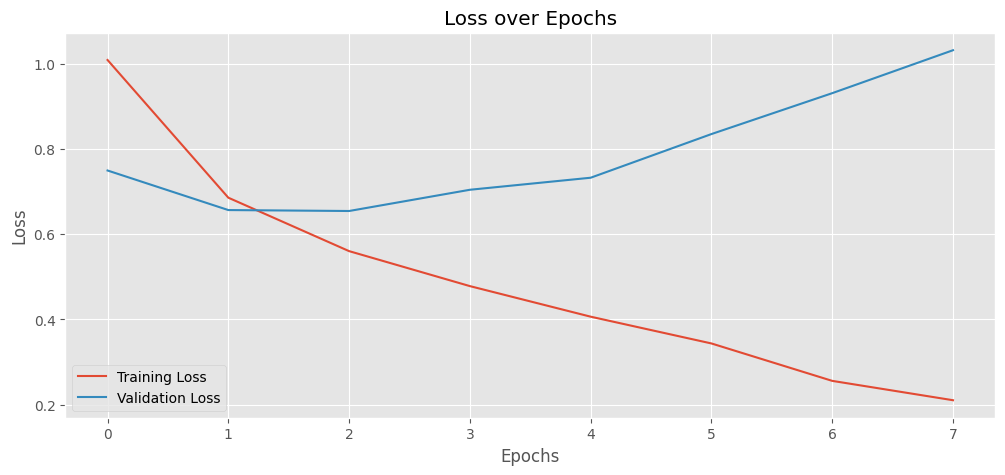

In [15]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)


319/319 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step
Weighted F1 Score: 0.7438
                      precision    recall  f1-score   support

             Anxiety       0.69      0.87      0.77       725
             Bipolar       0.78      0.73      0.75       500
          Depression       0.75      0.61      0.67      3019
              Normal       0.91      0.92      0.91      3189
Personality disorder       0.38      0.08      0.14       179
              Stress       0.48      0.46      0.47       459
            Suicidal       0.63      0.78      0.70      2128

            accuracy                           0.75     10199
           macro avg       0.66      0.64      0.63     10199
        weighted avg       0.75      0.75      0.74     10199



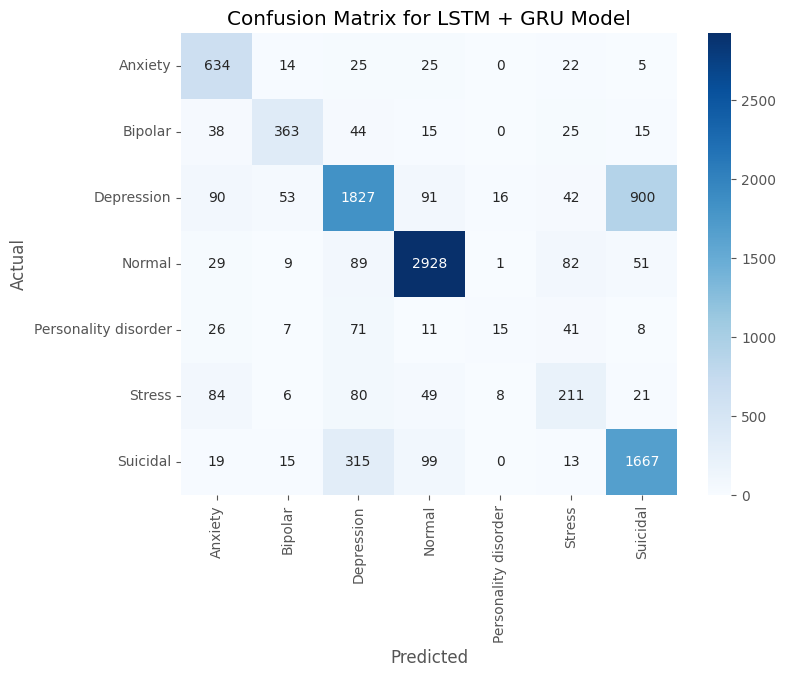

In [21]:
y_pred = model.predict({'text_input': X_test_seq, 'numeric_input': X_test_num})
y_pred_classes = np.argmax(y_pred, axis=1)
print(f'Weighted F1 Score: {f1_score(y_test_encoded, y_pred_classes, average="weighted"):.4f}')
print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix for LSTM + GRU Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Transformer Model (mental-bert)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

In [27]:
 # we dont use lemmatized text here because transformer models can understand semantics with full of sentences
X_train_text = X_train['cleaned_text'].values
X_test_text = X_test['cleaned_text'].values
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
X_train_num = X_train[['statement length', 'contains_num', 'capital_ratio', 'word_count', 'avg_word_length', 'sentence_count', 'avg_sentence_length']].values
X_test_num = X_test[['statement length', 'contains_num', 'capital_ratio', 'word_count', 'avg_word_length', 'sentence_count', 'avg_sentence_length']].values


**source model**: [mental-bert](https://huggingface.co/mental/mental-bert-base-uncased)

In [ ]:
bert_m = "mental/mental-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
model = AutoModel.from_pretrained("mental/mental-bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

### Multimodal (Text + Numeric Feature)

Using device: cuda
Train size: 40795
Test size: 10199
Numeric feature size: 7
Number of classes: 7


Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for 3 epochs...

Epoch 1/3


Validation: 100%|██████████| 638/638 [01:26<00:00,  7.36it/s]


Train Loss: 0.8268
Val Loss: 0.5587 | Val Acc: 0.7915 | Val F1: 0.7908
Best model saved with accuracy: 0.7915

Epoch 2/3


Validation: 100%|██████████| 638/638 [01:27<00:00,  7.33it/s]


Train Loss: 0.4484
Val Loss: 0.5160 | Val Acc: 0.8095 | Val F1: 0.8089
Best model saved with accuracy: 0.8095

Epoch 3/3


Validation: 100%|██████████| 638/638 [01:26<00:00,  7.38it/s]


Train Loss: 0.3244
Val Loss: 0.5492 | Val Acc: 0.8091 | Val F1: 0.8096

Training completed!

EVALUATION ON TEST SET


Predicting: 100%|██████████| 638/638 [01:26<00:00,  7.36it/s]



Weighted F1 Score: 0.8089

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.79      0.89      0.83       725
             Bipolar       0.87      0.76      0.81       500
          Depression       0.77      0.76      0.76      3019
              Normal       0.94      0.95      0.94      3189
Personality disorder       0.78      0.56      0.65       179
              Stress       0.59      0.68      0.63       459
            Suicidal       0.73      0.70      0.71      2128

            accuracy                           0.81     10199
           macro avg       0.78      0.76      0.76     10199
        weighted avg       0.81      0.81      0.81     10199



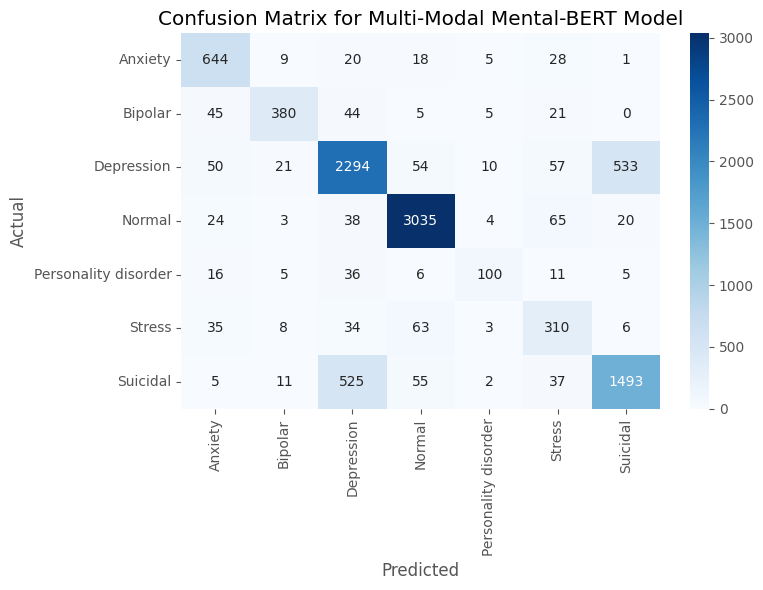


Model evaluation completed!


In [ ]:
class MultiModalDataset(Dataset):
    """Dataset for text + numeric features"""
    def __init__(self, texts, numeric_features, labels, tokenizer, max_length=128):
        # Convert to list to avoid pandas indexing issues
        self.texts = list(texts) if not isinstance(texts, list) else texts
        self.numeric_features = np.array(numeric_features)
        self.labels = list(labels) if not isinstance(labels, list) else labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        numeric = self.numeric_features[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numeric_features': torch.tensor(numeric, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class MultiModalMentalBERT(nn.Module):
    """Mental-BERT + Numeric Features Classifier"""
    def __init__(self, bert_model_name, num_classes, numeric_feature_size, dropout=0.3):
        super(MultiModalMentalBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        
        # Text branch
        self.text_dropout = nn.Dropout(dropout)
        
        # Numeric branch
        self.numeric_fc = nn.Sequential(
            nn.Linear(numeric_feature_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Combined classifier
        combined_size = self.bert.config.hidden_size + 64
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, input_ids, attention_mask, numeric_features):
        # BERT encoding
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_dropout(outputs.pooler_output)
        
        # Numeric encoding
        numeric_encoded = self.numeric_fc(numeric_features)
        
        # Concatenate features
        combined = torch.cat([text_features, numeric_encoded], dim=1)
        
        # Final classification
        logits = self.classifier(combined)
        return logits

class MultiModalTrainer:
    """Training pipeline for Multi-Modal Mental-BERT"""
    def __init__(self, model, train_loader, val_loader, device, lr=2e-5, epochs=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epochs = epochs
        
        # Optimizer and scheduler
        self.optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        total_steps = len(train_loader) * epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )
        self.criterion = nn.CrossEntropyLoss()
        
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
    
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(self.train_loader, desc='Training')
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            numeric_features = batch['numeric_features'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            self.optimizer.zero_grad()
            logits = self.model(input_ids, attention_mask, numeric_features)
            loss = self.criterion(logits, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        return total_loss / len(self.train_loader)
    
    def validate(self):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                numeric_features = batch['numeric_features'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                logits = self.model(input_ids, attention_mask, numeric_features)
                loss = self.criterion(logits, labels)
                total_loss += loss.item()
                
                preds = torch.argmax(logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / len(self.val_loader)
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted')
        
        return avg_loss, accuracy, f1, predictions, true_labels
    
    def predict(self, test_loader):
        """Generate predictions for test set"""
        self.model.eval()
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc='Predicting'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                numeric_features = batch['numeric_features'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                logits = self.model(input_ids, attention_mask, numeric_features)
                preds = torch.argmax(logits, dim=1)
                
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        return np.array(predictions), np.array(true_labels)
    
    def train(self):
        print(f"Starting training for {self.epochs} epochs...")
        best_accuracy = 0
        
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            
            train_loss = self.train_epoch()
            val_loss, val_acc, val_f1, preds, labels = self.validate()
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
            
            # Save best model
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                torch.save(self.model.state_dict(), 'best_multimodal_mental_bert.pt')
                print(f"Best model saved with accuracy: {best_accuracy:.4f}")
        
        print("\nTraining completed!")
        return self.train_losses, self.val_losses, self.val_accuracies

BERT_MODEL = "mental/mental-bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

print(f"Train size: {len(X_train_text)}")
print(f"Test size: {len(X_test_text)}")
print(f"Numeric feature size: {X_train_num.shape[1]}")
print(f"Number of classes: {len(encoder.classes_)}")

# Create datasets
train_dataset = MultiModalDataset(X_train_text, X_train_num, y_train_encoded, tokenizer, MAX_LENGTH)
test_dataset = MultiModalDataset(X_test_text, X_test_num, y_test_encoded, tokenizer, MAX_LENGTH)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize model
model = MultiModalMentalBERT(
    bert_model_name=BERT_MODEL,
    num_classes=len(encoder.classes_),
    numeric_feature_size=X_train_num.shape[1]
)

# Initialize trainer
trainer = MultiModalTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    device=device,
    lr=LEARNING_RATE,
    epochs=EPOCHS
)

# Train
train_losses, val_losses, val_accuracies = trainer.train()

# Load best model for evaluation
model.load_state_dict(torch.load('best_multimodal_mental_bert.pt'))
print("\n" + "="*60)
print("EVALUATION ON TEST SET")
print("="*60)

# Generate predictions on test set
y_pred_classes, y_test_encoded = trainer.predict(test_loader)
print(f'\nWeighted F1 Score: {f1_score(y_test_encoded, y_pred_classes, average="weighted"):.4f}')
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)
plt.title('Confusion Matrix for Multi-Modal Mental-BERT Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\nModel evaluation completed!")